In [3]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#load csv file with the correct delimiter 
file_path = 'malware-capture-csv/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv'
data = pd.read_csv(file_path, delimiter='|')



/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_30719/3556086763.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.replace('-', np.nan, inplace=True)
/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_30719/3556086763.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_selected.loc[:, 'duration'].fillna

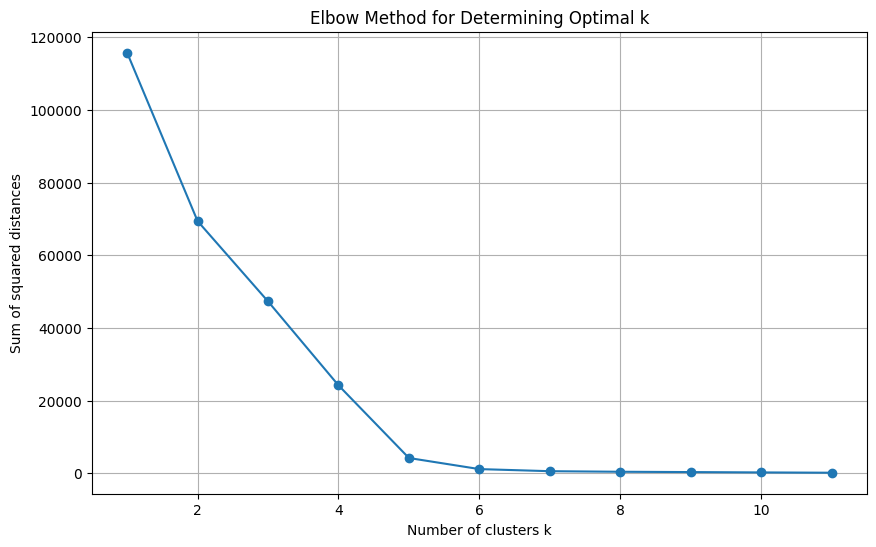

In [4]:
# Select relevant columns
selected_columns = [
    'ts', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 
    'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'label', 'orig_pkts'
]
data_selected = data[selected_columns]

# Data Cleaning
data_selected.replace('-', np.nan, inplace=True)
data_selected.loc[:, 'duration'] = pd.to_numeric(data_selected.loc[:, 'duration'], errors='coerce')
data_selected.loc[:, 'orig_bytes'] = pd.to_numeric(data_selected.loc[:, 'orig_bytes'], errors='coerce')
data_selected.loc[:, 'resp_bytes'] = pd.to_numeric(data_selected.loc[:, 'resp_bytes'], errors='coerce')

# Fill missing values
data_selected.loc[:, 'duration'].fillna(data_selected['duration'].median(), inplace=True)
data_selected.loc[:, 'orig_bytes'].fillna(0, inplace=True)
data_selected.loc[:, 'resp_bytes'].fillna(0, inplace=True)

# One-hot encode 'proto'
encoder = OneHotEncoder()
proto_encoded = encoder.fit_transform(data_selected[['proto']]).toarray()  # Convert sparse matrix to dense matrix

#==================================================================================================================================================
#==================================================================================================================================================
##### NEW FEATURE DOMAIN SPECIFIC INTERACTION 
# Calculate bytes per second for better granularity in traffic analysis
data_selected['bytes_per_second'] = data_selected['orig_bytes'] / data_selected['duration']

# Calculate packets per second to capture activity rate
data_selected['packets_per_second'] = data_selected['orig_pkts'] / data_selected['duration']

# Calculate time since last communication to identify regular patterns for DDoS
data_selected.sort_values('ts', inplace=True)

#Time since last communication for C&C
data_selected['last_communication'] = data_selected.groupby(['id.orig_h', 'id.resp_h'])['ts'].shift(1)
data_selected['time_since_last_comm'] = data_selected['ts'] - data_selected['last_communication']

# Handle Infinite or NaN values introduced by new feature calculations
data_selected.replace([np.inf, -np.inf], np.nan, inplace=True)
data_selected['bytes_per_second'].fillna(0, inplace=True)
data_selected['packets_per_second'].fillna(0, inplace=True)
data_selected['time_since_last_comm'].fillna(0, inplace=True)

# Count daily communications to detect frequent interactions typical for C&C
data_selected['date'] = pd.to_datetime(data_selected['ts'], unit='s').dt.date
daily_communication = data_selected.groupby(['id.orig_h', 'id.resp_h', 'date']).size().reset_index(name='daily_communications')
data_selected = data_selected.merge(daily_communication, on=['id.orig_h', 'id.resp_h', 'date'], how='left')

#==================================================================================================================================================
#==================================================================================================================================================

# Combine the encoded proto data with other numerical features
features = np.hstack((data_selected[['duration', 'orig_bytes', 'resp_bytes']].values, proto_encoded))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### CLUSTERING
# Determine the optimal number of clusters using the elbow method
sse = []
k_list = range(1, 12)  # Check from 1 to 12 clusters
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# Plot the SSE values for each k
plt.figure(figsize=(10, 6))
plt.plot(k_list, sse, marker='o')
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()



Statistics for Cluster 0:


,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,bytes_per_second,packets_per_second,last_communication,time_since_last_comm,daily_communications,cluster,label_encoded
count,2.131900e+04,21319.000000,21319.000000,21319.000000,2.131900e+04,21319.000000,21319.000000,2.131900e+04,21319.000000,2.128400e+04,21319.000000,21319.000000,21319.0,21319.000000
mean,1.545459e+09,59121.828697,2263.458089,3.906770,1.440175e+02,18.619682,5.720719,3.500466e+02,6.001703,1.545459e+09,34.076992,10496.471129,0.0,1.645387
std,2.160354e+04,13024.583008,5423.663087,6.149224,2.016995e+04,133.750550,136.333211,2.175151e+04,70.605613,2.156559e+04,917.231888,5390.949698,0.0,0.566819
min,1.545404e+09,0.000000,1.000000,0.000499,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.545404e+09,0.000000,1.000000,0.0,0.000000
25%,1.545467e+09,55032.000000,80.000000,3.110974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.545467e+09,0.000246,3484.000000,0.0,1.000000
50%,1.545467e+09,65279.000000,80.000000,3.110974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.545467e+09,0.000259,14260.000000,0.0,2.000000
75%,1.545467e+09,65279.000000,6667.000000,3.110974,0.000000e+00,0.000000,1.000000,0.000000e+00,0.321443,1.545467e+09,2.786042,14260.000000,0.0,2.000000
max,1.545490e+09,65279.000000,63798.000000,502.919185,2.945024e+06,17192.000000,5110.000000,3.137290e+06,2574.939125,1.545490e+09,73538.992202,14260.000000,0.0,3.000000


Statistics for Cluster 1:


,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,bytes_per_second,packets_per_second,last_communication,time_since_last_comm,daily_communications,cluster,label_encoded
count,1.813000e+03,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1.800000e+03,1813.000000,1813.000000,1813.0,1813.000000
mean,1.545434e+09,24624.787645,3056.401544,51.552882,39.635962,75.503585,3.404854,4475.638339,95.230845,1.545433e+09,258.573880,1603.577496,1.0,0.430226
std,2.237265e+04,25953.405644,4545.131136,1237.349740,336.648710,678.191150,29.240334,10287.199720,221.259571,2.229947e+04,2011.331366,1575.803404,0.0,0.511687
min,1.545404e+09,0.000000,1.000000,0.000497,0.000000,0.000000,1.000000,0.000000,0.012373,1.545404e+09,0.000000,1.000000,1.0,0.000000
25%,1.545414e+09,123.000000,123.000000,0.056719,0.000000,0.000000,1.000000,0.000000,0.321443,1.545414e+09,5.119850,136.000000,1.0,0.000000
50%,1.545428e+09,123.000000,123.000000,3.110974,0.000000,0.000000,1.000000,0.000000,0.953827,1.545428e+09,63.999782,503.000000,1.0,0.000000
75%,1.545449e+09,51758.000000,6667.000000,3.110974,48.000000,48.000000,3.000000,923.858650,19.247055,1.545449e+09,66.993032,3484.000000,1.0,1.000000
max,1.545490e+09,60459.000000,63798.000000,48976.819063,13115.000000,18031.000000,1023.000000,78470.824950,2012.072435,1.545490e+09,47537.965387,3484.000000,1.0,3.000000


Statistics for Cluster 2:


,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,bytes_per_second,packets_per_second,last_communication,time_since_last_comm,daily_communications,cluster,label_encoded
count,1.200000e+01,12.000000,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.0,12.0,12.0
mean,1.545404e+09,41121.833333,80.0,2.122035,149.833333,110899.500000,81.333333,96.941373,51.501560,1.545404e+09,9.869249,3484.0,2.0,0.0
std,5.045369e+02,86.198327,0.0,1.397724,1.337116,22806.114258,15.149757,46.878819,23.137761,5.105629e+02,19.265863,0.0,0.0,0.0
min,1.545404e+09,41040.000000,80.0,0.885992,148.000000,83792.000000,62.000000,31.836576,17.403995,1.545404e+09,0.029982,3484.0,2.0,0.0
25%,1.545404e+09,41045.500000,80.0,1.156277,149.000000,97467.500000,71.500000,58.210704,30.202461,1.545404e+09,1.044288,3484.0,2.0,0.0
50%,1.545404e+09,41078.000000,80.0,1.391330,149.500000,106796.000000,76.500000,108.271917,63.730754,1.545404e+09,4.108910,3484.0,2.0,0.0
75%,1.545405e+09,41203.000000,80.0,2.756992,151.000000,125113.250000,93.250000,130.815651,67.900129,1.545405e+09,7.205935,3484.0,2.0,0.0
max,1.545405e+09,41246.000000,80.0,4.711562,152.000000,164266.000000,114.000000,168.173076,75.729816,1.545405e+09,69.201389,3484.0,2.0,0.0


Statistics for Cluster 3:


,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,bytes_per_second,packets_per_second,last_communication,time_since_last_comm,daily_communications,cluster,label_encoded
count,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000e+00,1.000000,0.0,1.0,1.0,1.0,1.0
mean,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0
25%,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0
50%,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0
75%,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0
max,1.545474e+09,44924.0,5376.0,24.128182,75546624.0,0.0,18444.0,3.131053e+06,764.417311,NaN,0.0,1.0,3.0,2.0


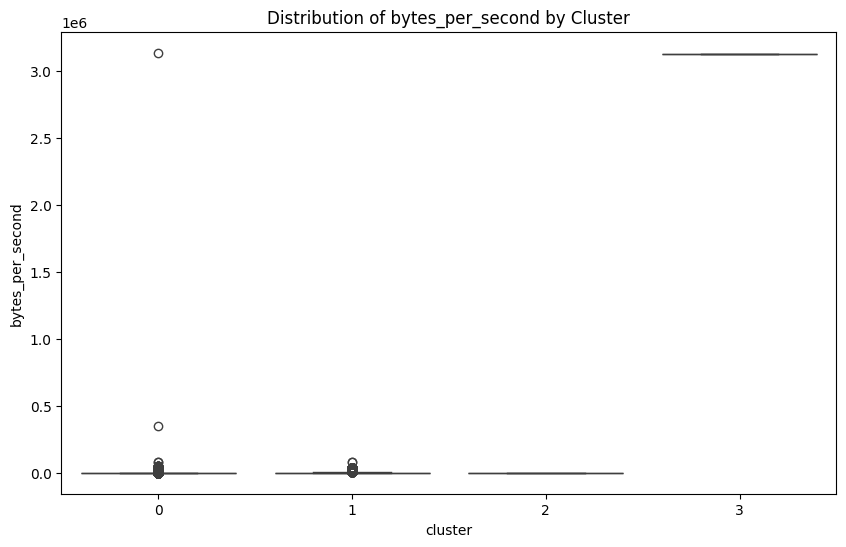

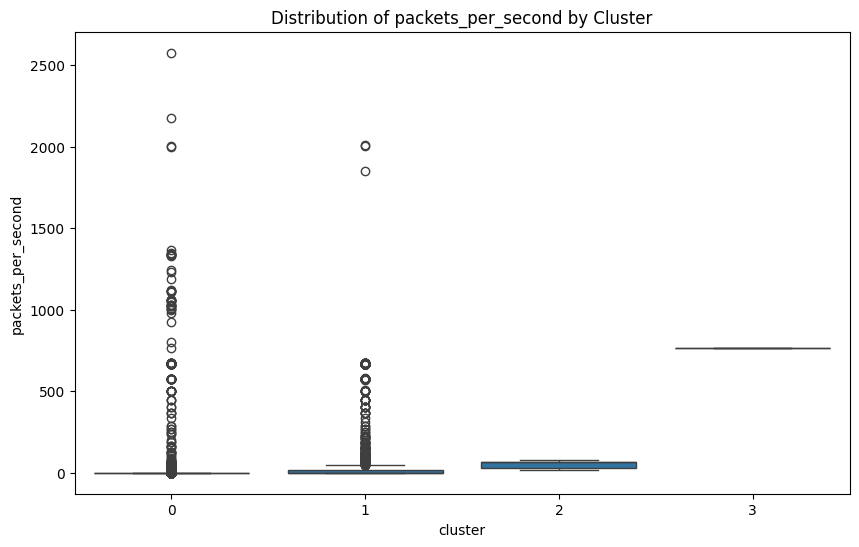

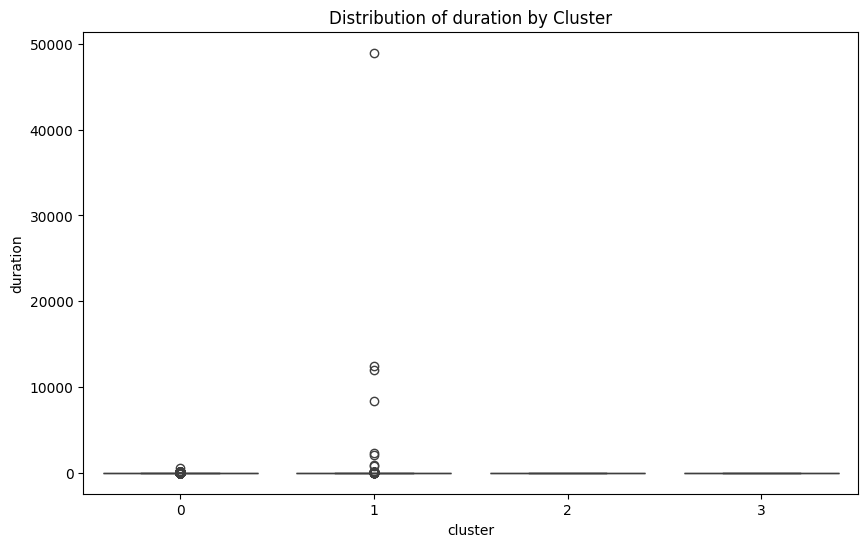

In [9]:
# More information on clusters on the table after domain feature cacluation 
#  Generating descriptive statistics for original features within each cluster
for i in range(4):
    cluster_data = data_selected[data_selected['cluster'] == i]
    print(f"Statistics for Cluster {i}:")
    display(cluster_data.describe())

# Feature importance for clusters can be approached by examining how features vary with clusters
for feature in ['bytes_per_second', 'packets_per_second', 'duration']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=data_selected)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

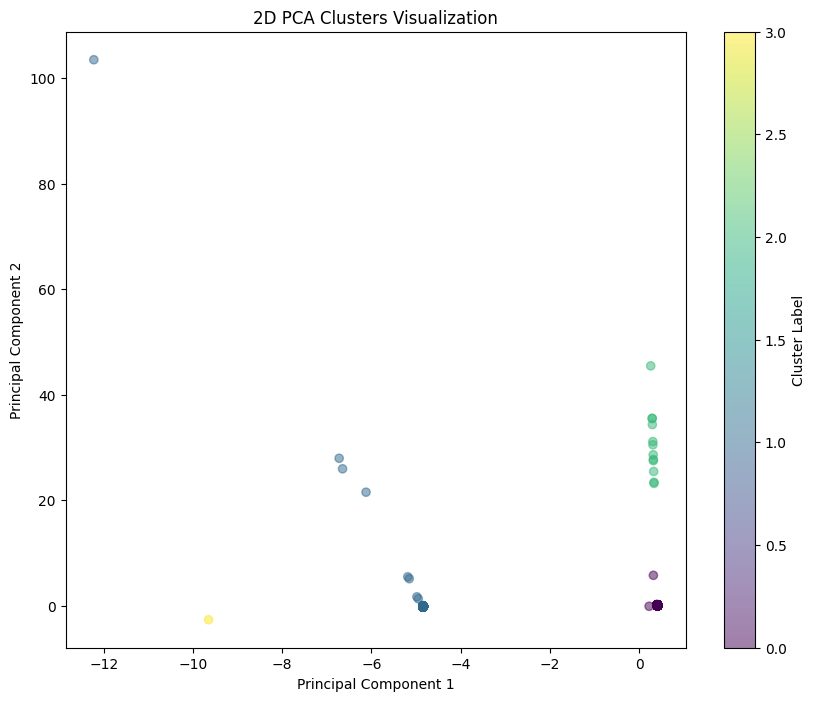

In [5]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Get cluster labels from K-means
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Create a scatter plot of the two principal component scores
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('2D PCA Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

## Cluster Analysis
To provide a specific analysis of each cluster based on the distributions of `bytes_per_second`, `packets_per_second`, and `duration`, we'll dig deeper into the behavior characteristics likely represented by each cluster. This analysis will help in understanding the potential types of network activity or behavior captured in each cluster, which can then be utilized for more targeted monitoring or action.

### Cluster 0: Minimal Activity
- **Characteristics**:
    - Very low bytes and packets per second.
    - Short durations dominate this cluster.
- **Possible Network Behaviors**: 
    - Likely represents idle or minimal network activity.
    - Could include keep-alive packets, background check-ins with servers, or other low-key maintenance/management traffic.
- **Actionable Insights**:
    - Generally low priority for security concerns.
    - Monitor for unexpected increases in activity that may suggest misuse or a change in behavior.

### Cluster 1: Standard Activity 
- **Characteristics**:
    - Moderate variability in bytes and packets per second, but generally low to moderate values.
    - Durations are short to moderate, indicating more active sessions than Cluster 0.
- **Possible Network Behaviors**: 
    - Typical user-generated traffic, such as web browsing, small file transfers, or standard API calls.
    - Could also include automated system updates or synchronization tasks.
- **Actionable Insights**:
    - Monitor for consistency and patterns that align with expected behaviors.
    - Sudden changes or anomalies could suggest system issues or security concerns.

### Cluster 2: High Activity
- **Characteristics**:
    - High bytes and packets per second, indicating heavy data transfer.
    - A mix of short and long durations, suggesting a variety of intensive activities.
- **Possible Network Behaviors**: 
    - This could include large file downloads/uploads, streaming activities, or extensive use of cloud services.
    - Potentially includes bulk data processing or transfer sessions.
- **Actionable Insights**:
    - Given the high volume of data transfer, it’s important to ensure that this activity is legitimate and authorized.
    - Monitoring for data exfiltration or unwanted exposure should be prioritized.

### Cluster 3: Extremely High Activity 
- **Characteristics**:
    - Extremely high data rates and significant packet transfers, coupled with longer session durations.
- **Possible Network Behaviors**: 
    - This cluster is indicative of the most intense network activities, possibly including continuous data streaming, large-scale backups, or even DDoS attacks.
    - The nature and impact of such activities could vary widely, from critical business operations to potential security threats.
- **Actionable Insights**:
    - Activities in this cluster should be subject to high scrutiny, especially to distinguish between critical operations and potential security threats.
    - Specific security protocols might be needed to either safeguard or shut down these activities depending on their legitimacy and impact.

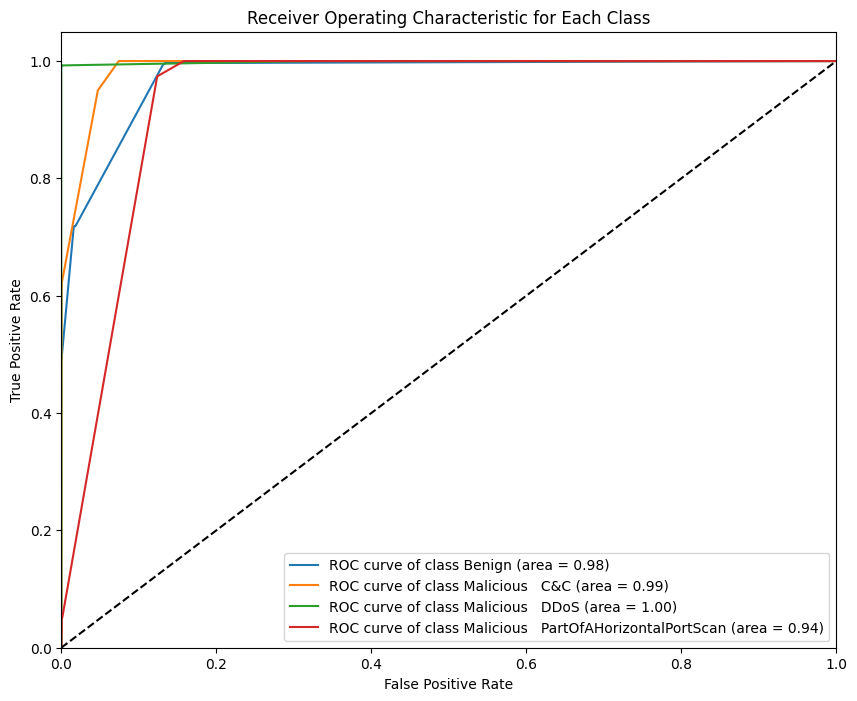

In [6]:
# K-means clustering (use elbow method results to pick k)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
data_selected['cluster'] = cluster_labels

# Ensure all relevant features are included and properly scaled
features = np.hstack((data_selected[['duration', 'orig_bytes', 'resp_bytes', 'bytes_per_second', 'packets_per_second']].values, proto_encoded))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Supervised Learning Preparation
label_encoder = LabelEncoder()
data_selected['label_encoded'] = label_encoder.fit_transform(data_selected['label'])
X = features_scaled  # Features already scaled
y = data_selected['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Evaluation on Accuracy 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_pred_proba = rf_classifier.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

In [7]:
# Predict on the test set and evaluate the model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9514688940092166
Confusion Matrix:
 [[ 415  164    0    0]
 [ 101 1907    0    0]
 [   0   32 4285    1]
 [   2   36    1    0]]
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       579
           1       0.89      0.95      0.92      2008
           2       1.00      0.99      1.00      4318
           3       0.00      0.00      0.00        39

    accuracy                           0.95      6944
   macro avg       0.67      0.66      0.67      6944
weighted avg       0.95      0.95      0.95      6944



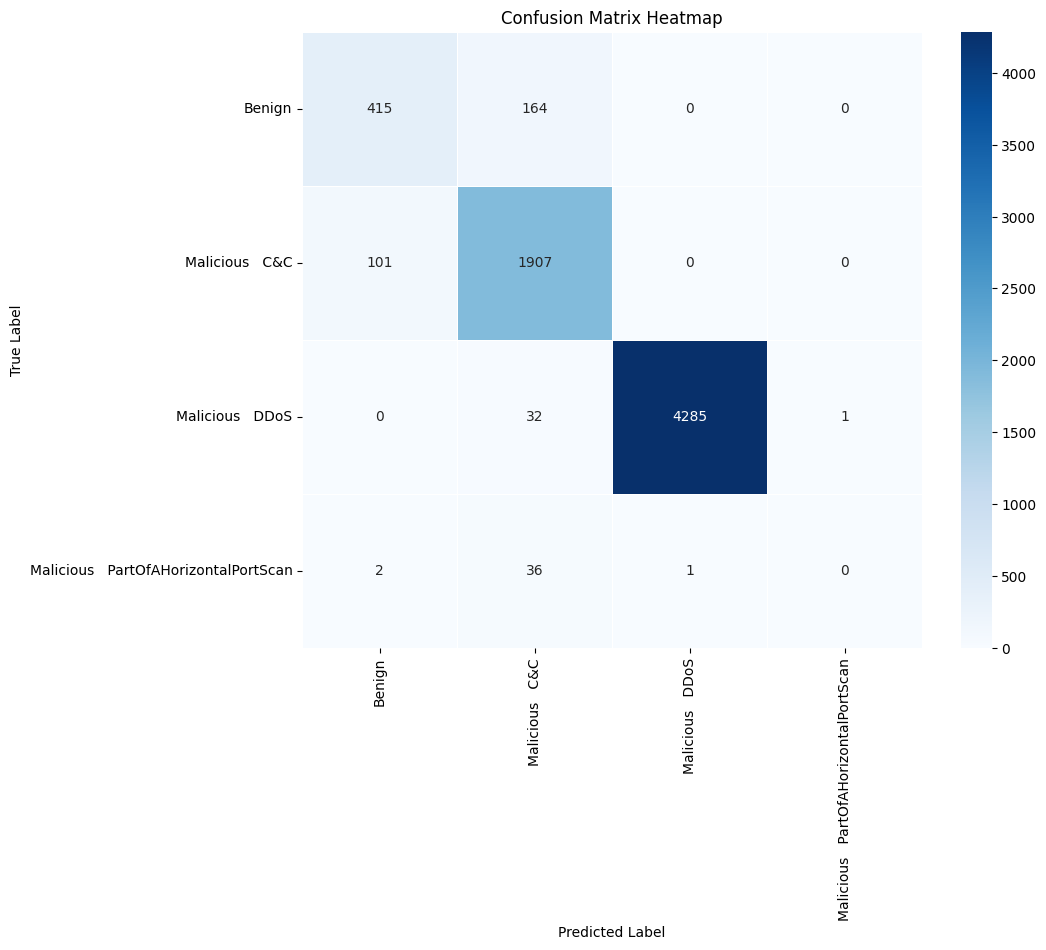

In [23]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Poential Fixes & Improvements:

- Use isolation forest for anomally detection for extremely high cases (Cluster 3/ Hortizonatal Port Scan)
- Try to continue to fix the confusion between C&C and Benign 